In [11]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter1d
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Rectangle

# Essential Functions
Includes function to detect peaks and valleys of signal. Parameter delta to determine how many peaks/valleys detected (higher delta, fewer peaks)

In [12]:
def peakdet(v, delta, x = None):
    """
    Converted from MATLAB script at http://billauer.co.il/peakdet.html
    P
    Returns two arrays
    
    function [maxtab, mintab]=peakdet(v, delta, x)
    %PEAKDET Detect peaks in a vector
    %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
    %        maxima and minima ("peaks") in the vector V.
    %        MAXTAB and MINTAB consists of two columns. Column 1
    %        contains indices in V, and column 2 the found values.
    %      
    %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
    %        in MAXTAB and MINTAB are replaced with the corresponding
    %        X-values.
    %
    %        A point is considered a maximum peak if it has the maximal
    %        value, and was preceded (to the left) by a value lower by
    %        DELTA.
    
    % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
    % This function is released to the public domain; Any use is allowed.
    
    """
    maxtab = []
    mintab = []
       
    if x is None:
        x = np.arange(len(v))
    
    v = np.asarray(v)
    
    if len(v) != len(x):
        print('Input vectors v and x must have same length')
        return
    
    if not np.isscalar(delta):
        print('Input argument delta must be a scalar')
        return
    
    if delta <= 0:
        print('Input argument delta must be positive')
        return
    
    mn, mx = np.Inf, -np.Inf
    mnpos, mxpos = np.NaN, np.NaN
    
    lookformax = True
    
    for i in np.arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return np.array(maxtab), np.array(mintab)


def get_valleys(x, n):
    
    """return the indices of n valleys in given signal x.
    Each valley to be separated by at least <SPACE> samples.
    delta automatically incremented until n beats are detected (after excluding valleys that are too close to one another).
    """
    
    SPACE = 100 # number of samples between each valley
    
    def get_included_valleys(too_close, valleys):        
        exclude = []
        for i in too_close:
            ind_to_exclude = i if (valleys[i] > valleys[i + 1]) else (i+1)
            exclude.append(ind_to_exclude)
        include = [k for k in range(len(valleys)) if k not in exclude]
        return np.array(include)
    
    def get_spaced_valleys(delta):
        _, valleys = peakdet(x, delta)
        # valleys, _ = peakdet(x, delta)
        inds = valleys[:,0]
        diff = np.array([inds[i] - inds[i-1] for i in range(1,len(inds))])
        too_close = np.where(diff < SPACE)[0]
        include = get_included_valleys(too_close, valleys[:,1])
        actual_inds = inds[include]
        return actual_inds

    delta = 1000
    actual_inds = get_spaced_valleys(delta)
    num_beats = len(actual_inds)
    
    # vary delta to ensure there are 100 valleys
    while num_beats > n:
        delta += 10
        actual_inds = get_spaced_valleys(delta)
        num_beats = len(actual_inds)
        
    return np.uint16(actual_inds)

# Visualize Individual Trial
Code to visualize data of individual file. To actually create the combined dataset, go straight to section **Create Combined Dataset**.

In [13]:
DATA_PATH = "data/right/"
FILE = "0-1.csv"
df = pd.read_csv(DATA_PATH + FILE, index_col=0)
print(df.shape)
df.tail()

(32728, 7)


,gesture,time,index,middle,ring,pinky,accX
32723,0-1,1.679472e+09,699.0,675.0,721.0,710.0,-540.0
32724,0-1,1.679472e+09,699.0,675.0,721.0,710.0,-544.0
32725,0-1,1.679472e+09,699.0,675.0,721.0,710.0,-548.0
32726,0-1,1.679472e+09,699.0,675.0,721.0,711.0,-549.0
32727,0-1,1.679472e+09,699.0,675.0,721.0,711.0,-548.0


Frequency: 311.695 Hz
Number of beats: 100


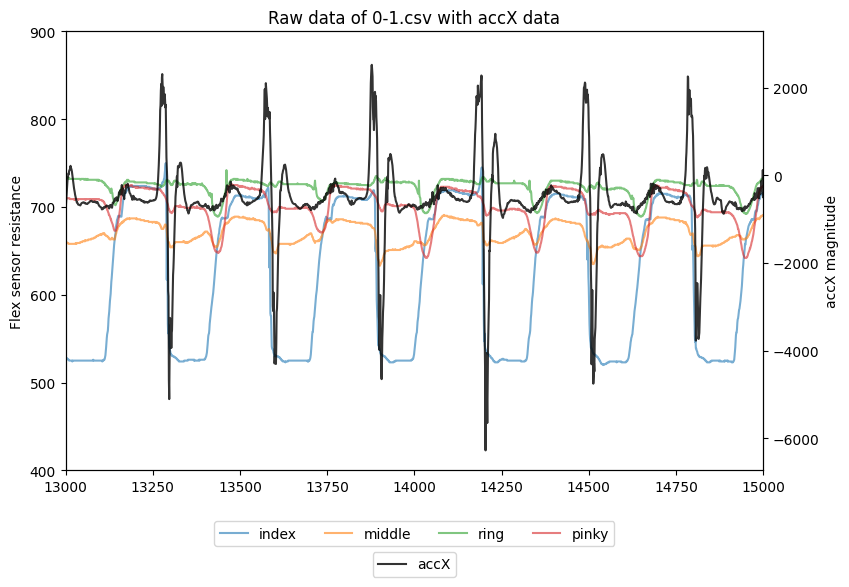

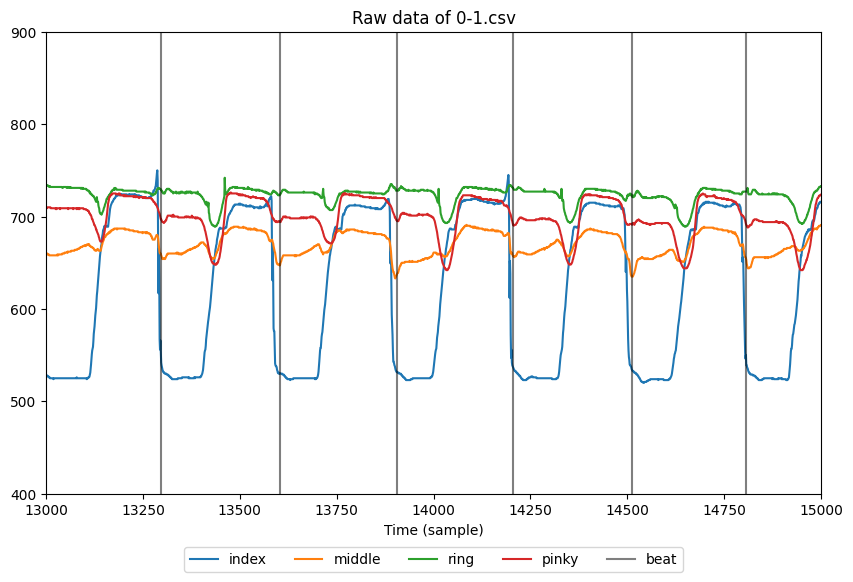

In [14]:
keys = ["index","middle","ring","pinky"]
offset = 200
NUM_BEATS = 100

# get x-axis in seconds
startTime = int(df.iloc[0,1])
endTime = int(df.iloc[-1,1])
x = np.linspace(0, endTime-startTime, df.shape[0])

# get valleys
if "NOBEATS" in FILE:
    valleys = [(1000 + 240*i) for i in range(NUM_BEATS)]
else:
    accX = df['accX'].to_numpy()
    valleys = get_valleys(accX, NUM_BEATS)

# print stats
print("Frequency: %.3f Hz" % (df.shape[0]/(endTime-startTime)))
print("Number of beats:", len(valleys))

# plot data
fig, ax1 = plt.subplots()
fig.set_size_inches((9, 5.7))
ax2 = ax1.twinx()
for key in keys:
    ax1.plot(df[key].to_numpy(), label=key, alpha=0.6)
ax2.plot(df["accX"].to_numpy(), color="k", label="accX", alpha=0.8)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.17), ncol=5)
plt.xlabel("Time (sample)")
ax1.set_ylabel("Flex sensor resistance")
ax2.set_ylabel("accX magnitude")
plt.xlim(13000,15000)
ax1.set_ylim((400,900))
plt.title("Raw data of " + FILE + " with accX data")
# plt.title("Gesture data for Kick-Hihat with accX data (Freq=%.2fHz)" % (df.shape[0]/(endTime-startTime)))
plt.show()

plt.figure(figsize=(10, 6)) 
for key in keys:
    plt.plot(np.arange(0, len(x)), df[key].to_numpy(), label=key)
for i in range(len(valleys)):
    plt.axvline(valleys[i], color="k", alpha=0.5, label="beat" if not i else "")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5)
plt.xlabel("Time (sample)")
plt.xlim(13000,15000)
plt.ylim((400,900))
plt.title("Raw data of " + FILE)
# plt.title("Gesture data for Kick-Hihat with beats indicated (Freq=%.2fHz)" % (df.shape[0]/(endTime-startTime)))
# plt.grid()
plt.show()

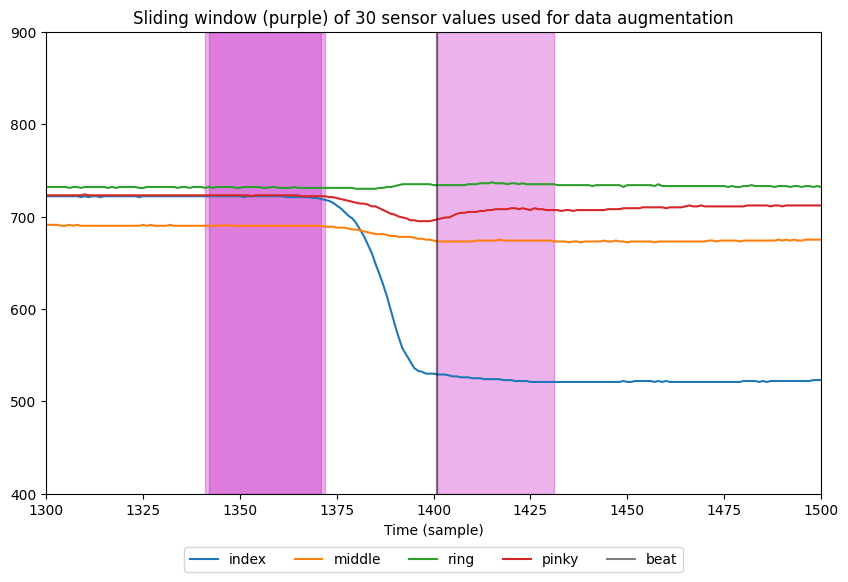

In [49]:
# plt.figure(figsize=(10, 6)) 
beat = 1401
fig, ax = plt.subplots()
fig.set_size_inches((10, 6))
for key in keys:
    ax.plot(np.arange(0, len(x)), df[key].to_numpy(), label=key)
for i in range(len(valleys)):
    ax.axvline(valleys[i], color="k", alpha=0.5, label="beat" if not i else "")
ax.add_patch(Rectangle((beat-60, 400), 30, 500, color="m", alpha=0.3))
ax.add_patch(Rectangle((beat-59, 400), 30, 500, color="m", alpha=0.3))
ax.add_patch(Rectangle((beat, 400), 30, 500, color="m", alpha=0.3))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5)
ax.set_xlabel("Time (sample)")
ax.set_xlim(1300,1500)
ax.set_ylim((400,900))
plt.title("Sliding window (purple) of 30 sensor values used for data augmentation")
plt.show()

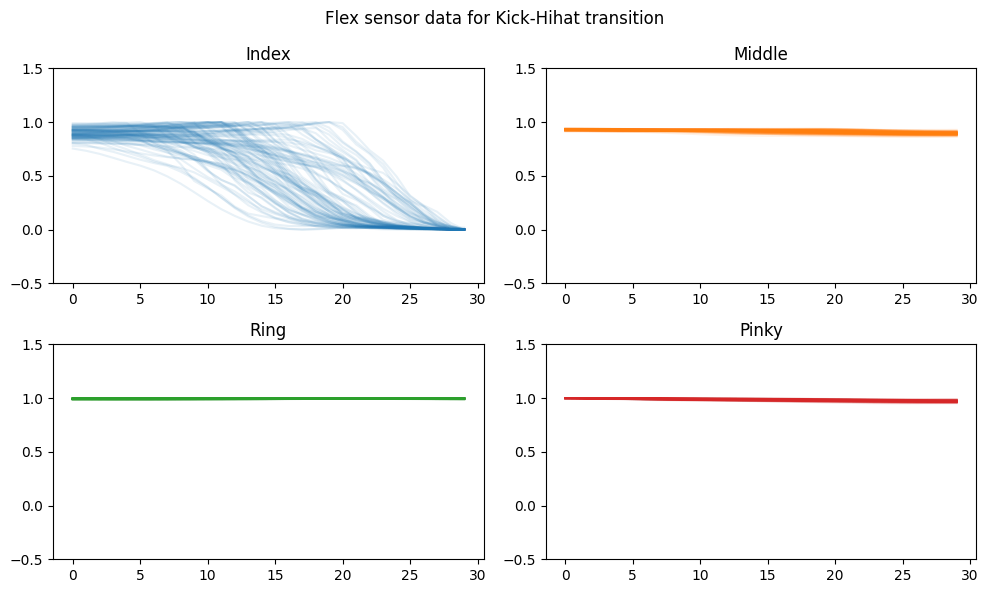

In [9]:
timestep = 30
offset = 0

# get indices of beats
df_gesture = df.loc[:,["index","middle","ring","pinky"]].to_numpy()
X = np.empty([len(valleys), timestep, 4])

fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(10, 6)

# split, filter and normalize data
alpha = 0.1
for i in range(len(valleys)):
    idx = valleys[i]
    gesture_data = df_gesture[idx-offset-timestep : idx-offset, :]
    filtered_data = uniform_filter1d(gesture_data, axis=0, size=5)
    for j in range(4):
        # filtered_data[:,j] = filtered_data[:,j] - np.mean(filtered_data[:,j])
        data_min, data_max = np.min(filtered_data), np.max(filtered_data)
        filtered_data[:,j] = (filtered_data[:,j] - data_min) / (data_max - data_min)
    X[i] = filtered_data
    ax[0,0].plot(filtered_data[:,0], color="C0", alpha=alpha)
    ax[0,1].plot(filtered_data[:,1], color="C1", alpha=alpha)
    ax[1,0].plot(filtered_data[:,2], color="C2", alpha=alpha)
    ax[1,1].plot(filtered_data[:,3], color="C3", alpha=alpha)
        
ymin = min(X.flatten()) - 0.5
ymax = max(X.flatten()) + 0.5

ax[0,0].set_title("Index")
ax[0,1].set_title("Middle")
ax[1,0].set_title("Ring")
ax[1,1].set_title("Pinky")
for a in ax.flatten():
    a.set_ylim((ymin, ymax))
# plt.suptitle(FILE)
plt.suptitle("Flex sensor data for Kick-Hihat transition")
plt.tight_layout()
plt.show()

# Create Combined Dataset
Code to actually create the combined dataset. DataFrame has 2000 rows (samples) and 5 columns: index, middle, ring, pinky and label. Labels contain strings representing gesture transitions (e.g. 0-1) and the data samples are lists of 30 samples each.

In [3]:
def create_dataset():
    DATA_PATH = "../data/"
    NUM_BEATS = 100
    timestep = 30
    offset = 10 # number of samples before beat to take samples

    files = []
    for filename in os.listdir(DATA_PATH):
        f = os.path.join(DATA_PATH, filename)
        files.append(f)
    files.sort()

    data = {
        "index": [],
        "middle": [],
        "ring": [],
        "pinky": [],
        "label": []
    }
    for i in range(len(files)):
        file = files[i]

        # create dataframe
        df = pd.read_csv(file, index_col=0)

        # get gesture
        gesture = df.iloc[0,0]
        
        # get beats indices
        # get valleys
        if "NOBEATS" in file:
            valleys = [(1000 + 240*i) for i in range(NUM_BEATS)]
        else:
            accX = df['accX'].to_numpy()
            valleys = get_valleys(accX, NUM_BEATS)
        df_gesture = df.loc[:,["index","middle","ring","pinky"]].to_numpy()    
        print("%s: %d beats" % (file, len(valleys)))

        # split, filter and normalize data
        for idx in valleys:
            offset_range = np.arange(-10,10) if "NOBEATS" in file else np.arange(-30,30)
            for offset in offset_range:
                gesture_data = df_gesture[idx-offset-timestep : idx-offset, :]
                filtered_data = uniform_filter1d(gesture_data, axis=0, size=10)
                for k in range(4):
                    # filtered_data[:,k] = filtered_data[:,k] - np.mean(filtered_data[:,k])
                    # filtered_data[:,k] = filtered_data[:,k] - np.mean(filtered_data)
                    data_min, data_max = np.min(filtered_data), np.max(filtered_data)
                    filtered_data[:,k] = (filtered_data[:,k] - data_min) / (data_max - data_min)
                data["index"].append(list(filtered_data[:,0]))
                data["middle"].append(list(filtered_data[:,1]))
                data["ring"].append(list(filtered_data[:,2]))
                data["pinky"].append(list(filtered_data[:,3]))
                data["label"].append(gesture)

    final_df = pd.DataFrame(data)
    return final_df

In [5]:
final_df = create_dataset()
final_df.to_csv("data_nomean.csv")

../data/0-0-NOBEATS.csv: 100 beats
../data/0-0-endeavouros.csv: 100 beats
../data/0-1-endeavouros.csv: 100 beats
../data/0-2-endeavouros.csv: 100 beats
../data/0-3.csv: 100 beats
../data/0-4.csv: 100 beats
../data/1-0.csv: 100 beats
../data/1-1-NOBEATS.csv: 100 beats
../data/1-1.csv: 100 beats
../data/1-2.csv: 100 beats
../data/1-3.csv: 100 beats
../data/1-4.csv: 100 beats
../data/2-0.csv: 100 beats
../data/2-1.csv: 100 beats
../data/2-2-NOBEATS.csv: 100 beats
../data/2-2.csv: 100 beats
../data/2-3.csv: 100 beats
../data/2-4.csv: 100 beats
../data/3-0.csv: 100 beats
../data/3-1.csv: 100 beats
../data/3-2.csv: 100 beats
../data/3-3-NOBEATS.csv: 100 beats
../data/3-3.csv: 100 beats
../data/3-4.csv: 100 beats
../data/4-0.csv: 100 beats
../data/4-1.csv: 100 beats
../data/4-2.csv: 100 beats
../data/4-3.csv: 100 beats
../data/4-4-NOBEATS.csv: 100 beats
../data/4-4.csv: 100 beats
